# 实验说明
本实验的主要内容为：在CIFAR-10数据集上训练一个神经网络，了解训练和推理（预测）的基本流程、探究神经网络的设计（包括网络结构、超参数）对模型性能的影响。
> CIFAR-10数据集，又称加拿大高等研究院数据集（Canadian Institute for Advanced Research）是一个常用于训练机器学习和计算机视觉算法的图像集合。它是最广泛使用的机器学习研究数据集之一。CIFAR-10数据集包含60,000张32×32像素的彩色图像，分为10个不同的类别。这10个类别分别是飞机、汽车、鸟类、猫、鹿、狗、青蛙、马、船和卡车，每个类别有6,000张图片。——维基百科

在进行实验前，最好对以下内容有所了解：
- 基础的Python语法；
- 机器学习领域的基本概念与基础的数学知识（参见[动手学深度学习](https://zh.d2l.ai/index.html)1-3章）；
- 神经网络的基本概念（如全连接层、卷积层、池化层，参见[动手学深度学习](https://zh.d2l.ai/index.html)4-6章）。

# 实验要求
实验基础代码已经在下面给出。你需要保证自己在熟悉了基础代码后，完成Task1~Task4中选择至少3个完成。
- 截止日期：$\text{2025.4.6 23:59}$
- 提交内容：源代码、实验报告、模型权重文件
- 报告要求：提交pdf版本实验报告，包括摘要、引言、方法、实验以及总结部分，4页左右。如果你在探索中有任何其它发现或想法，也请加入到报告中。
# 实验报告说明
0. **摘要（Abstract）**：引⾔的⼀个⾼度浓缩版本，通过⼀段话介绍你研究的所有内容。
1. **引⾔（Introduction）**：这是摘要的⼀个扩写版本，包含更多⼀些的细节。通过⼏段话（2-3段）总结整个报告的内容，让读者通过阅读引⾔就可以知道你做的具体内容。⼀般包括：要解决的问题、⽬标、相关技术背景、你的实验思路和主要实验结论。
2. **方法（Methodology）**：介绍你具体的实验思路，详细定义研究问题，详细描述实验⽅法，要求简单、精炼、准确。有必要的话需要给出具体的算法。
3. **实验（Experiments）**：包括实验设置（Experimental Setup）和实验结果（Main Results）两个部分。其中，实验设置介绍模型、数据集、超参数设置等；实验结果以图、表的形式介绍每组实验的结果和发现。
4. **总结（Conclusion）**：以简短的⼀段话总结整个报告。
# 实验基础代码
机器学习可大致分为三个部分：数据、模型以及算法。下面，我们按照这一顺序给出实验的基础代码。

# 实验分数说明
共四个子任务，每个3分，实验报告8分

# 0. 导入必要的库

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
show = ToPILImage()

# 1. 准备训练数据与测试数据
首先我们介绍数据部分。`torchvision`库已经为我们直接提供了CIFAR-10数据集的下载，我们就不需要手动地去网上下载了。代码中的`transform`将原始的图像转换为模型易于处理的形式。`trainloader`和`testloader`分别用于加载训练集和测试集。

In [2]:
# 设定对图片的归一化处理方式，并且下载数据集
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./dataset', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./dataset', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


通过运行下面的代码，可得知CIFAR-10数据集的训练集包含50000张图像，每张图像的大小为32*32；数据集中的每个元素是由数据和对应的标签组成的。

In [3]:
# 观察一下数据集的内容
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # 类别名称
print(len(trainset)) # 训练集大小
print(trainset[0][0].size()) # 第 1 条数据的图像大小
print(trainset[0][1]) # 第 1 条数据的标签
print(classes[trainset[0][1]]) # 第 1 条数据的文本标签

50000
torch.Size([3, 32, 32])
6
frog


下面这段代码在训练集中随意抽出一张进行可视化，注意在展示之前我们需要将其做上述`transform`的逆变换：

torch.Size([3, 32, 32])
7
horse


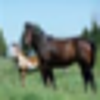

In [4]:
# 1 - 4行与上一块代码意义类似
(data, label) = trainset[12] # 选群训练集的一个样本展示内容，也可以改成其他数字看看
print(data.size()) 
print(label) # label是整数
print(classes[label])
show((data + 1) / 2).resize((100, 100)) # 还原被归一化的图片

# 2. 定义用于分类的网络结构

这一部分我们定义用于图像分类的网络结构，实现一个早期的卷积神经网络LeNet。它由两个卷积层和三个全连接层组成。pytorch为我们提供了方便的接口定义神经网络，但我们这里不着重介绍具体的语法，只观察数据是怎样在模型中“流动”的：
- 在`__init__`方法中，我们将上述的卷积层和全连接层初始化为`conv1、conv2`和`fc1、fc2、fc3`；
- 卷积层以`conv1`为例，它的初始化为`Conv2d(3, 6, 5)`，即：3输入通道（RGB图像的三个通道）、6输出通道、5*5大小的卷积核的卷积层。
- 全连接层以`fc1`为例，它的初始化为`Linear(16 * 5 * 5, 120)`，即：从400维映射到120维。
- `forward`方法用于规定数据在模型中的计算过程。输入的形状在传播过程中的变化参见`forward`中的注释。最终，我们得到了一个大小为`[batch size, 10]`的张量（矩阵）。

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        # nn.Module子类的函数必须在构造函数中执行父类的构造函数
        super(Net, self).__init__()

        # 卷积层 '3'表示输入图片为单通道, '6'表示输出通道数，'5'表示卷积核为5*5
        self.conv1 = nn.Conv2d(3, 6, 5) 
        # 卷积层
        self.conv2 = nn.Conv2d(6, 16, 5) 
        # 仿射层/全连接层，y = Wx + b
        self.fc1   = nn.Linear(16*5*5, 120) 
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x): 
        # 卷积 -> 激活 -> 池化 (relu激活函数不改变输入的形状)
        # [batch size, 3, 32, 32] -- conv1 --> [batch size, 6, 28, 28] -- maxpool --> [batch size, 6, 14, 14]
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # [batch size, 6, 14, 14] -- conv2 --> [batch size, 16, 10, 10] --> maxpool --> [batch size, 16, 5, 5]
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # 把 16 * 5 * 5 的特征图展平，变为 [batch size, 16 * 5 * 5]，以送入全连接层
        x = x.view(x.size()[0], -1) 
        # [batch size, 16 * 5 * 5] -- fc1 --> [batch size, 120]
        x = F.relu(self.fc1(x))
        # [batch size, 120] -- fc2 --> [batch size, 84]
        x = F.relu(self.fc2(x))
        # [batch size, 84] -- fc3 --> [batch size, 10]
        x = self.fc3(x)        
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


# 3. 模型训练与测试过程
准备好数据、定义好模型后，我们开始训练过程。为了把一个随机初始化的模型优化成一个“好”的模型，我们还需要定义：
- 损失函数$\mathcal{L}$：损失函数以一般同时以模型的预测$\hat{y}$和真实的标签$y$为输入，输出一个标量。这个标量越小，说明模型在数据上拟合得越好。我们的目的就是要最小化这个损失函数$\mathcal{L}(\hat{y},y).$分类问题常使用交叉熵函数作为损失函数。
- 优化方法：为了最小化损失函数，我们就要使用数学的优化方法找到一组最优的参数（这里的参数即神经网络中卷积层、全连接层等的参数，而非batch size等超参数）。深度学习中一般使用迭代的方式求解，常用的方法有SGD（随机梯度下降）、Adam等。
pytorch库内置了各种优化器，我们无需手动实现梯度下降过程。

In [6]:
from torch import optim
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # 使用SGD（随机梯度下降）优化
num_epochs = 5 # 训练 5 个 epoch

下面我们定义用于训练过程的代码。最外层循环控制在整个数据集上训练的次数（即epoch）；内层循环按照以下流程进行：
1. 取出数据（一次取出一个batch）；
2. 将数据送入网络，计算损失函数；
3. 使用损失函数计算梯度，进行反向传播更新参数。

In [7]:
def train(trainloader, net, num_epochs, criterion, optimizer, save_path):
    for epoch in range(num_epochs):     
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
    
            # 1. 取出数据
            inputs, labels = data
    
            # 梯度清零
            optimizer.zero_grad()
    
            # 2. 前向计算和反向传播
            outputs = net(inputs) # 送入网络（正向传播）
            loss = criterion(outputs, labels) # 计算损失函数
            
            # 3. 反向传播，更新参数
            loss.backward() # 反向传播
            optimizer.step()

            # 下面的这段代码对于训练无实际作用，仅用于观察训练状态
            running_loss += loss.item()
            if i % 2000 == 1999: # 每2000个batch打印一下训练状态
                print('epoch %d: batch %5d loss: %.3f' \
                      % (epoch+1, i+1, running_loss / 2000))
                running_loss = 0.0
                
        torch.save(net.state_dict(), f"{save_path}/epoch_{epoch + 1}_model.pth")
        
    print('Finished Training')

In [19]:
# 使用定义的网络进行训练
save_path = '<input your path>'
train(trainloader, net, num_epochs, criterion, optimizer, save_path)

epoch 1: batch  1000 loss: 0.449
epoch 1: batch  2000 loss: 0.475
epoch 1: batch  3000 loss: 0.475
epoch 1: batch  4000 loss: 0.485
epoch 1: batch  5000 loss: 0.479
epoch 1: batch  6000 loss: 0.471
epoch 1: batch  7000 loss: 0.490
epoch 1: batch  8000 loss: 0.486
epoch 1: batch  9000 loss: 0.491
epoch 1: batch 10000 loss: 0.488
epoch 1: batch 11000 loss: 0.503
epoch 1: batch 12000 loss: 0.498
Finished Training


训练过程结束后，我们得到了一个在训练集上拟合较好的模型。下面我们要测试它在测试集上表现如何。预测的代码与训练中的正向传播类似，但是不需要计算损失函数（损失函数在实验中仅用于更新参数，预测时参数固定，也就不需要它了）。

预测的流程如下：
1. 取出数据；
2. 正向传播，得到模型的输出结果；
3. 从输出结果中得到模型预测；
4. 和真实标签进行比对，计算性能指标。

注意：模型的输出结果在第2部分中已经说明，为一个`[batch size, 10]`大小的张量（矩阵），每一行是一条数据属于10个类别的概率的相对大小（这一输出也被称为`logits`）。为了得到模型的预测，我们需要对这一输出在每行上取最大值，取得最大值的**位置**就是模型的预测。

In [12]:
def predict(testloader, net):
    correct = 0 # 预测正确的图片数
    total = 0 # 总共的图片数
    
    with torch.no_grad(): # 正向传播时不计算梯度
        for data in testloader:
            # 1. 取出数据
            images, labels = data
            # 2. 正向传播，得到输出结果
            outputs = net(images)
            # 3. 从输出中得到模型预测
            _, predicted = torch.max(outputs, 1)
            # 4. 计算性能指标
            total += labels.size(0)
            correct += (predicted == labels).sum()
    
    print('测试集中的准确率为: %d %%' % (100 * correct / total))

In [20]:
predict(testloader, net)

测试集中的准确率为: 59 %



# Task1：绘制损失函数曲线
损失函数能够量化模型在数据集上的拟合程度，帮助我们了解模型训练的进程。请在`3.模型训练与测试过程`中补充代码，记录训练过程中损失`loss`的变化，使用合适的Python数据类型将其保存，并使用`matplotlib`库将其可视化。可参照以下的代码进行绘图。你可以直接用损失函数可视化的代码覆盖下面的代码块。

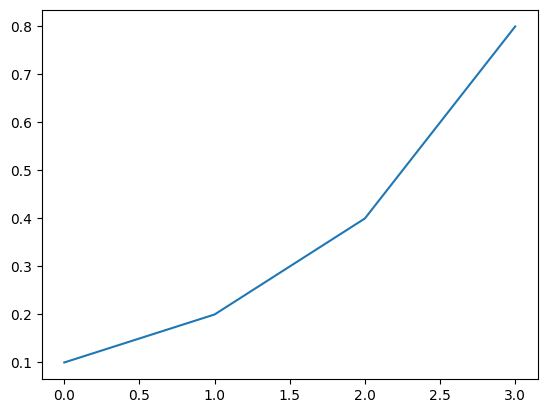

In [9]:
import matplotlib.pyplot as plt

def draw(values):
    plt.plot(values)
    plt.show()

draw([0.1, 0.2, 0.4, 0.8])

请在报告中附上训练过程中损失函数的变化。训练集上的损失越小，说明模型的效果就越好吗？

# Task2: 加入正则化

- $L_2$正则化：请查阅Pytorch[有关SGD优化器的文档](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#sgd)或其它网络资料，修改`3. 模型训练与测试过程`中的代码，尝试为模型的损失函数加入一项$L_2$损失，并在报告中说明你所做的修改。
- Dropout正则化：请查阅Pytorch[有关Dropout层的文档](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#dropout)或其它网络资料，修改`2. 定义用于分类的网络结构`中的代码，在**第一个线性层和第二个线性层之间**加入一个Dropout层，并在报告中说明你所做的修改。
- 在报告中简述两种正则化方法的基本原理。

In [ ]:
# TODO: 在Dropout_Net中加入dropout层
class Dropout_Net(nn.Module):
    def __init__(self):
        # nn.Module子类的函数必须在构造函数中执行父类的构造函数
        super(Dropout_Net, self).__init__()

        # 卷积层 '1'表示输入图片为单通道, '6'表示输出通道数，'5'表示卷积核为5*5
        self.conv1 = nn.Conv2d(3, 6, 5) 
        # 卷积层
        self.conv2 = nn.Conv2d(6, 16, 5) 
        # 仿射层/全连接层，y = Wx + b
        self.fc1   = nn.Linear(16*5*5, 120) 
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x): 
        # 卷积 -> 激活 -> 池化 
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        # reshape，‘-1’表示自适应
        x = x.view(x.size()[0], -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x
    
dropout_net = Dropout_Net()

In [ ]:
# TODO: 在这里重新定义optimizer，加入L2正则化项

# 使用新定义的网络和优化器进行训练与测试
train(trainloader, dropout_net, num_epochs, criterion, optimizer)
predict(testloader, dropout_net)

# Task3: 调整参数
在`3. 模型训练与测试过程`部分中，我们定义了一些超参数（如`num_epoch`、优化器的`lr`）。调节这些参数，观察损失函数以及模型在测试集上的性能变化，在报告中简要说明这些指标的变化，尝试分析这些超参数对整个模型的影响。

In [ ]:
# TODO: 在这里修改参数，重新进行训练和测试，并记录数据

# Task4: 实现自己的网络
查阅资料（参考：[动手学深度学习](https://zh.d2l.ai/chapter_convolutional-modern/index.html)以及[`torchvision`的模型源码](https://github.com/pytorch/vision/tree/main/torchvision/models)），修改`2. 定义用于分类的网络结构`中的代码，实现一种现代卷积神经网络。与最基础的LeNet相比，你实现的神经网络在性能、训练时间上有何差异？

In [ ]:
# TODO: 参考2.中Net的实现，设计自己的网络，进行训练和测试，并记录数据